# The Stochastic Shortest Path Problem

Modeling optimal solution with MDP(Markov Decision Process).
The problem: We want to find an optimal policy to deploy to the autonomous agent given
some constraints we defined. 

In [19]:
# Import the needed libs
import networkx as nx
from collections import defaultdict
from GridWorld import GridWorld
import matplotlib.pyplot as plt
import numpy as np
import os

## Defining the MDP and Value iteration algorithm

In [28]:
class MDP:
    def __init__(self, N, states, startState = None, endState = None, rewards = dict(), transitions = None, policy = None):
        self.N = N
        self.states = set(states)
        self.startState = startState
        self.endState = endState
        assert type(rewards) == dict
        # should be state : action : reward
        self.rewards = rewards
        assert type(transitions) == dict
        # should be current state : actions : next state : probability
        self.transitions = transitions
        self.actions = set()
        for action in transitions.values():
            for key in action.keys():
                self.actions.add(key)
        
        

        self.policy = policy
    
    def getStateCount(self):
        return len(self.states)
    
    def getStartState(self):
        return self.startState
    def setStartState(self, state):
        if state not in self.states:
            return "State not present"
        self.startState = state
        
    def getEndState(self):
        return self.endState
    def setEndState(self, state):
        if state not in self.states:
            return "State not present"
        self.endState = state

In [27]:
class valueIteration:
    def __init__(self, mdp, gamma):
        self.mdp = mdp
        self.values = {state: 0 for state in mdp.states}
        self.values[self.mdp.getEndState()] = 0
        self.gamma = gamma

    def Q(self, state, action):
        ans = self.mdp.rewards[state][action]
        temp = 0
        for nextState, probability in self.mdp.transitions[state][action].items():
            temp += probability * self.values[nextState]
        ans += self.gamma * temp
        return ans

    def singleStep(self):
        delta = 0
        temp = {state: float("-100") for state in self.mdp.states}
        temp[self.mdp.getEndState()] = 0
        for state, rest in self.mdp.transitions.items():
            for action in rest.keys():
                Q = self.Q(state, action)
                temp[state] = max(temp[state], Q)
            delta = max(delta, abs(temp[state] - self.values[state]))
        self.values = temp
        # print(self.values)
        return delta
        
    def getPolicy(self):
        self.policy = dict()

        for state in states:
            if state not in transitions:
                print(f"No posible transitions for {state}")
                self.policy[state] = None  
                continue
    
            bestAction = None
            bestValue = float('-inf')
    
            for action in transitions[state]:
                expectedReward = 0
                
                for nextState, prob in transitions[state][action].items():
                    expectedReward += prob * self.values.get(nextState, 0)
                # print(state, action, nextState, prob, expectedReward)
                if expectedReward > bestValue:
                    bestValue = expectedReward
                    bestAction = action
    
            self.policy[state] = bestAction
    
        return self.policy
    
        

    def train(self, DELTA = 1e-4):
        delta = self.singleStep()
        iterCount = 1
        while delta > DELTA:
            iterCount += 1
            delta = self.singleStep()
        print(f"Converged in {iterCount} iterations")
        print(self.values)
        for state, action in self.getPolicy().items():
            print(f" In state {state} take action: {action}.")
    

## States and graph definition: Examples

First example of a graph for the stochastic shortest path problem.

### Example 1: Finding the optimal route from home to work

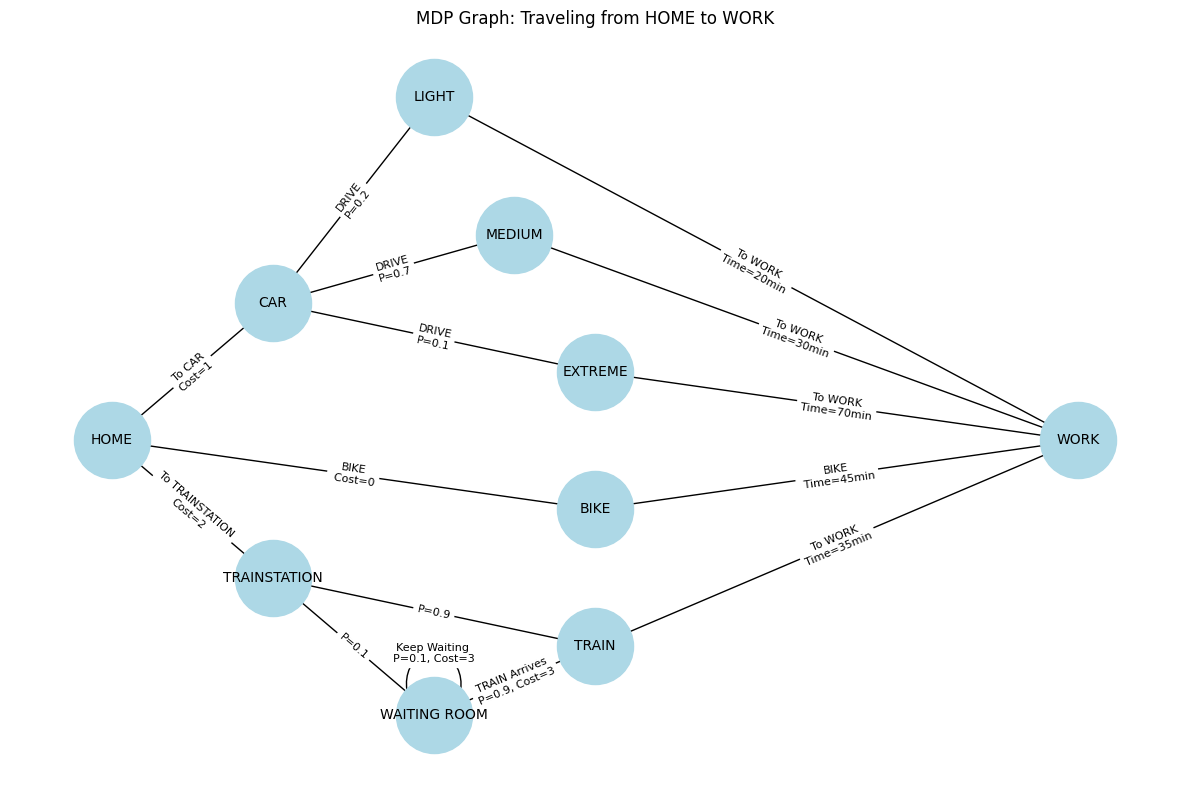

In [29]:
# States
states = ["HOME", "BIKE", "CAR", "TRAINSTATION",
    "LIGHT", "MEDIUM", "EXTREME",
    "TRAIN", "WAITING ROOM", "WORK"]

# Graph
G = nx.DiGraph()

# Deterministic route: BIKE
G.add_edge("HOME", "BIKE", label="BIKE\n Cost=0")
G.add_edge("BIKE", "WORK", label="BIKE\n Time=45min")

# Stochastic route: CAR
G.add_edge("HOME", "CAR", label="To CAR\nCost=1")
G.add_edge("CAR", "LIGHT", label="DRIVE\nP=0.2")
G.add_edge("CAR", "MEDIUM", label="DRIVE\nP=0.7")
G.add_edge("CAR", "EXTREME", label="DRIVE\nP=0.1")
G.add_edge("LIGHT", "WORK", label="To WORK\nTime=20min")
G.add_edge("MEDIUM", "WORK", label="To WORK\nTime=30min")
G.add_edge("EXTREME", "WORK", label="To WORK\nTime=70min")

# Stochastic route: TRAINSTATION
G.add_edge("HOME", "TRAINSTATION", label="To TRAINSTATION\nCost=2")
G.add_edge("TRAINSTATION", "TRAIN", label="P=0.9")
G.add_edge("TRAINSTATION", "WAITING ROOM", label="P=0.1")
G.add_edge("TRAIN", "WORK", label="To WORK\nTime=35min")
G.add_edge("WAITING ROOM", "TRAIN", label="TRAIN Arrives\nP=0.9, Cost=3")
G.add_edge("WAITING ROOM", "WAITING ROOM", label="Keep Waiting \nP=0.1, Cost=3")

# Graph layout
pos = {
    "HOME": (0, 0),
    "WORK": (6, 0),
    "BIKE": (3, -0.5),
    "CAR": (1, 1),
    "LIGHT": (2, 2.5),
    "MEDIUM": (2.5, 1.5),
    "EXTREME": (3, 0.5),
    "TRAINSTATION": (1, -1),
    "WAITING ROOM": (2, -2),
    "TRAIN": (3, -1.5),
}

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrows=True)

# Edge labeling
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("MDP Graph: Traveling from HOME to WORK")
plt.axis("off")
plt.tight_layout()
plt.show()

In [30]:
states = [
    "HOME", "CAR", "LIGHT", "MEDIUM", "EXTREME",
    "TRAINSTATION", "WAITING ROOM", "TRAIN", "WORK", "BIKE"
]

startState = "HOME"
endState = "WORK"

N = len(states)

# ============================
# TRANSITIONS
# ============================

transitions = {
    "HOME": {
        "bike": {"BIKE": 1.0},
        "to_car": {"CAR": 1.0},
        "to_trainstation": {"TRAINSTATION": 1.0},
    },
    "CAR": {
        "drive": {
            "LIGHT": 0.2,
            "MEDIUM": 0.7,
            "EXTREME": 0.1
        }
    },
    "BIKE": {
        "to_work": {"WORK": 1.0}
    },
    "LIGHT": {
        "to_work": {"WORK": 1.0}
    },
    "MEDIUM": {
        "to_work": {"WORK": 1.0}
    },
    "EXTREME": {
        "to_work": {"WORK": 1.0}
    },
    "TRAINSTATION": {
        "take_train": {
            "TRAIN": 0.9,
            "WAITING ROOM": 0.1
        }
    },
    "TRAIN": {
        "to_work": {"WORK": 1.0}
    },
    "WAITING ROOM": {
        "waiting": {
            "TRAIN": 0.9,
            "WAITING ROOM": 0.1
        }
    }
}

# ============================
# REWARDS
# ============================

rewards = {
    "HOME": {
        "bike": 0,
        "to_car": -1,
        "to_trainstation": -2
        
    },
    "BIKE": {
        "to_work": -45
    },
    "CAR": {
        "drive": 0
    },
    "LIGHT": {
        "to_work": -20
    },
    "MEDIUM": {
        "to_work": -30
    },
    "EXTREME": {
        "to_work": -70
    },
    "TRAINSTATION": {
        "take_train": 0
    },
    "TRAIN": {
        "to_work": -35
    },
    "WAITING ROOM": {
        "waiting": -3     
    },
}

goToWork = MDP(N = N, states = states, startState = "HOME", endState = "WORK", rewards = rewards, transitions = transitions)
policy = valueIteration(goToWork, 1.0)
policy.train()

Converged in 8 iterations
{'HOME': -33.0, 'TRAIN': -35.0, 'WORK': 0, 'WAITING ROOM': -38.3333298, 'CAR': -32.0, 'MEDIUM': -30.0, 'TRAINSTATION': -35.3333298, 'BIKE': -45.0, 'EXTREME': -70.0, 'LIGHT': -20.0}
No posible transitions for WORK
 In state HOME take action: to_car.
 In state CAR take action: drive.
 In state LIGHT take action: to_work.
 In state MEDIUM take action: to_work.
 In state EXTREME take action: to_work.
 In state TRAINSTATION take action: take_train.
 In state WAITING ROOM take action: waiting.
 In state TRAIN take action: to_work.
 In state WORK take action: None.
 In state BIKE take action: to_work.


### Example 2: Deciding how to spend the evening to achive maximum happiness

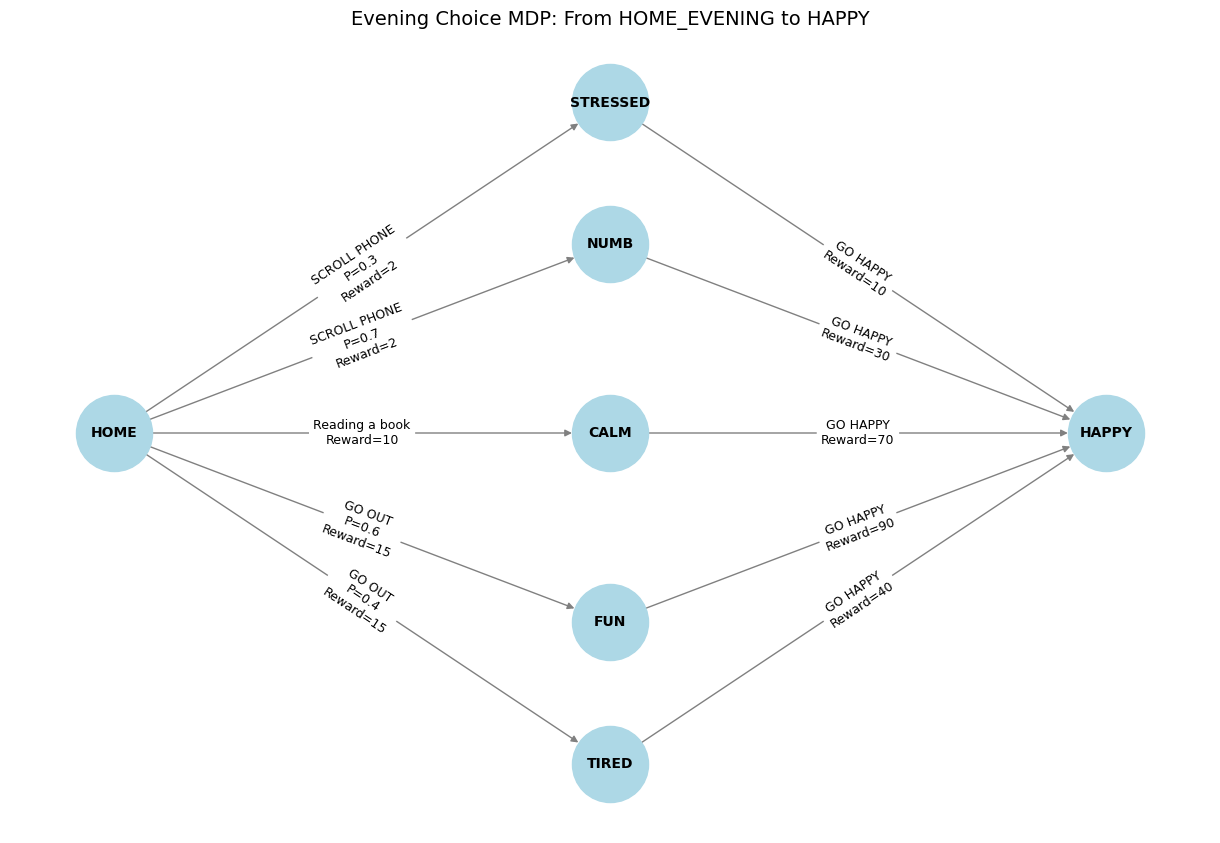

In [50]:
# States
states = [
    "HOME", "CALM", "FUN", "TIRED", "NUMB", "STRESSED", "HAPPY"
]
# Graph
G = nx.DiGraph()

# Deterministic route: READ
G.add_edge("HOME", "CALM", label="Reading a book\nReward=10")

# Stochastic route: GO OUT
G.add_edge("HOME", "FUN", label="GO OUT\nP=0.6\nReward=15")
G.add_edge("HOME", "TIRED", label="GO OUT\nP=0.4\nReward=15")

# Stochastic route: SCROLL PHONE
G.add_edge("HOME", "NUMB", label="SCROLL PHONE\nP=0.7\nReward=2")
G.add_edge("HOME", "STRESSED", label="SCROLL PHONE\nP=0.3\nReward=2")



# Rewards
G.add_edge("FUN", "HAPPY", label="GO HAPPY\nReward=90")
G.add_edge("TIRED", "HAPPY", label="GO HAPPY\nReward=40")
G.add_edge("CALM", "HAPPY", label="GO HAPPY\nReward=70")
G.add_edge("NUMB", "HAPPY", label="GO HAPPY\nReward=30")
G.add_edge("STRESSED", "HAPPY", label="GO HAPPY\nReward=10")



# Stochastic route: TRAINSTATION
# G.add_edge("HOME", "TRAINSTATION", label="To TRAINSTATION\nCost=2")
# G.add_edge("TRAINSTATION", "TRAIN", label="P=0.9")
# G.add_edge("TRAINSTATION", "WAITING ROOM", label="P=0.1")
# G.add_edge("TRAIN", "WORK", label="To WORK\nTime=35min")
# G.add_edge("WAITING ROOM", "TRAIN", label="TRAIN Arrives\nP=0.9, Cost=3")
# G.add_edge("WAITING ROOM", "WAITING ROOM", label="Keep Waiting \nP=0.1, Cost=3")

# Graph layout
pos = {
    "HOME": (0, 0),
    "HAPPY": (6, 0),
    "FUN": (3, -2),
    "TIRED": (3, -3.5),
    "CALM": (3, 0),
    "NUMB": (3, 2),
    "STRESSED": (3, 3.5)
}

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, font_weight='bold', edge_color='gray', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
plt.title("Evening Choice MDP: From HOME_EVENING to HAPPY", fontsize=14)
plt.axis("off")
plt.show()

In [51]:
states = [
    "HOME_EVENING", "CALM", "FUN", "TIRED", "NUMB", "STRESSED", "HAPPY"
]

startState = "HOME_EVENING"
endState = "HAPPY"

rewards = {
    "HOME_EVENING": {
        "READ_BOOK": 10,        
        "GO_OUT": 15,           
        "SCROLL_PHONE": 2       
    },
    "FUN": {
        "GO_HAPPY": 90
    },
    "TIRED": {
        "GO_HAPPY": 40
    },
    "CALM": {
        "GO_HAPPY": 70
    },
    "NUMB": {
        "GO_HAPPY": 30
    },
    "STRESSED": {
        "GO_HAPPY": 10
    }
}

transitions = {
    "HOME_EVENING": {
        "READ_BOOK": {
            "CALM": 1.0
        },
        "GO_OUT": {
            "FUN": 0.6,
            "TIRED": 0.4
        },
        "SCROLL_PHONE": {
            "NUMB": 0.7,
            "STRESSED": 0.3
        }
    },
    "FUN": {
        "GO_HAPPY": {
            "HAPPY": 1.0
        }
    },
    "TIRED": {
        "GO_HAPPY": {
            "HAPPY": 1.0
        }
    },
    "CALM": {
        "GO_HAPPY": {
            "HAPPY": 1.0
        }
    },
    "NUMB": {
        "GO_HAPPY": {
            "HAPPY": 1.0
        }
    },
    "STRESSED": {
        "GO_HAPPY": {
            "HAPPY": 1.0
        }
    }
}
goToWork = MDP(N = N, states = states, startState = "HOME", endState = "WORK", rewards = rewards, transitions = transitions)
policy = valueIteration(goToWork, 0.9)
policy.train()

Converged in 4 iterations
{'CALM': -20.0, 'HAPPY': -100.0, 'NUMB': -60.0, 'FUN': 0.0, 'STRESSED': -80.0, 'HOME_EVENING': -3.0, 'TIRED': -50.0, 'WORK': 0}
No posible transitions for HAPPY
 In state HOME_EVENING take action: READ_BOOK.
 In state CALM take action: GO_HAPPY.
 In state FUN take action: GO_HAPPY.
 In state TIRED take action: GO_HAPPY.
 In state NUMB take action: GO_HAPPY.
 In state STRESSED take action: GO_HAPPY.
 In state HAPPY take action: None.
